# Histogram of the Dimuon Mass Spectrum

This implements the dimuon mass spectrum analysis, a "Hello World!" example for data analysis in High Energy Physics. It is intended as a technology demonstrator for the use Apache Spark for High Energy Physics.

The workload and data:
  - The input data is a series of candidate muon events. 
  - The job output is a histogram of the dimuon mass spectrum, where several peaks (resonances) can be identified corresponding to well-know particles (e.g. the Z boson at 91 Gev).
  - The computation is based on https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8C.html and CERN open data from the CMS collaboration linked there. 
  - See also https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics
  
Author and contact: Luca.Canali@cern.ch  
Last updated for Spark 4 data source: September 2025  
Original version January, 2022  


## Dimuon mass spectrum calculation with Spark DataFrame API

In [1]:
# Install PySpark 4.x
!pip install --upgrade pyspark

# Install sparkhistogram
!pip install sparkhistogram

# Install pyspark_root_datasource
!pip install pyspark_root_datasource

In [1]:
# Start the Spark Session
# This uses local mode for simplicity

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("Dimuon mass")
         .master("local[4]")
         .config("spark.driver.memory", "2g")
         .getOrCreate()
        )


In [2]:
from pyspark_root_datasource import register

# Register the datasource (short name = "root")
# This works with Spark version >= 4.0.0
register(spark)

In [4]:
# Read data with the muon candidate events
# This requires # XRootD client libs + Python bindings
# ! pip install fsspec fsspec-xrootd
# !conda install -c conda-forge xrootd
# Or else download the data (2 GB) if reading via XRootD does not work 
# ! wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012BC_DoubleMuParked_Muons.root

file="root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root"

df_muons = spark.read.format("root").load(file)
    
df_muons.printSchema()
print(f"Number of events: {df_muons.count()}")

root
 |-- nMuon: integer (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)



[Stage 0:========================================================>(61 + 1) / 62]

Number of events: 61540413


In [5]:
# Apply filters to the input data
# - select only events with 2 muons
# - select only events where the 2 muons have opposite charge

df_muons = df_muons.filter("nMuon == 2").filter("Muon_charge[0] != Muon_charge[1]")


In [6]:
# This computes the 4-vectors sum for the 2-muon system
# using formulas from special relativity, in the limit E >> muons rest mass
# see also http://edu.itp.phys.ethz.ch/hs10/ppp1/2010_11_02.pdf
# and https://en.wikipedia.org/wiki/Invariant_mass

df_with_dimuonmass = df_muons.selectExpr("""
     sqrt(2 * Muon_pt[0] * Muon_pt[1] * 
             ( cosh(Muon_eta[0] - Muon_eta[1]) - cos(Muon_phi[0] - Muon_phi[1]) )
         ) as Dimuon_mass""")

In [7]:
# This defines the DataFrame transformation to compute the Dimuon mass spectrum
# The result is a histogram with (energy) bin values and event counts foreach bin

# Requires sparkhistogram
# See https://github.com/LucaCanali/Miscellaneous/blob/master/Spark_Notes/Spark_DataFrame_Histograms.md 
from sparkhistogram import computeHistogram

# histogram parameters
min_val = 0.25
max_val = 300
num_bins = 30000

# use the helper function computeHistogram in the package sparkhistogram
histogram_data = computeHistogram(df_with_dimuonmass, "Dimuon_mass", min_val, max_val, num_bins) 


In [8]:
# The action toPandas() triggers the computation (Spark uses lazy evaluation)
# Histogram data is fetched into the driver as a Pandas DataFrame.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 179 ms, sys: 23 ms, total: 202 ms
Wall time: 42.6 s


In [9]:
# Preview of the histogram data
histogram_data_pandas.head(5)

,bucket,value,count
0,1,0.254995833333333,19679
1,2,0.264987500000000,19285
2,3,0.274979166666667,18972
3,4,0.284970833333333,18543
4,5,0.294962500000000,18520


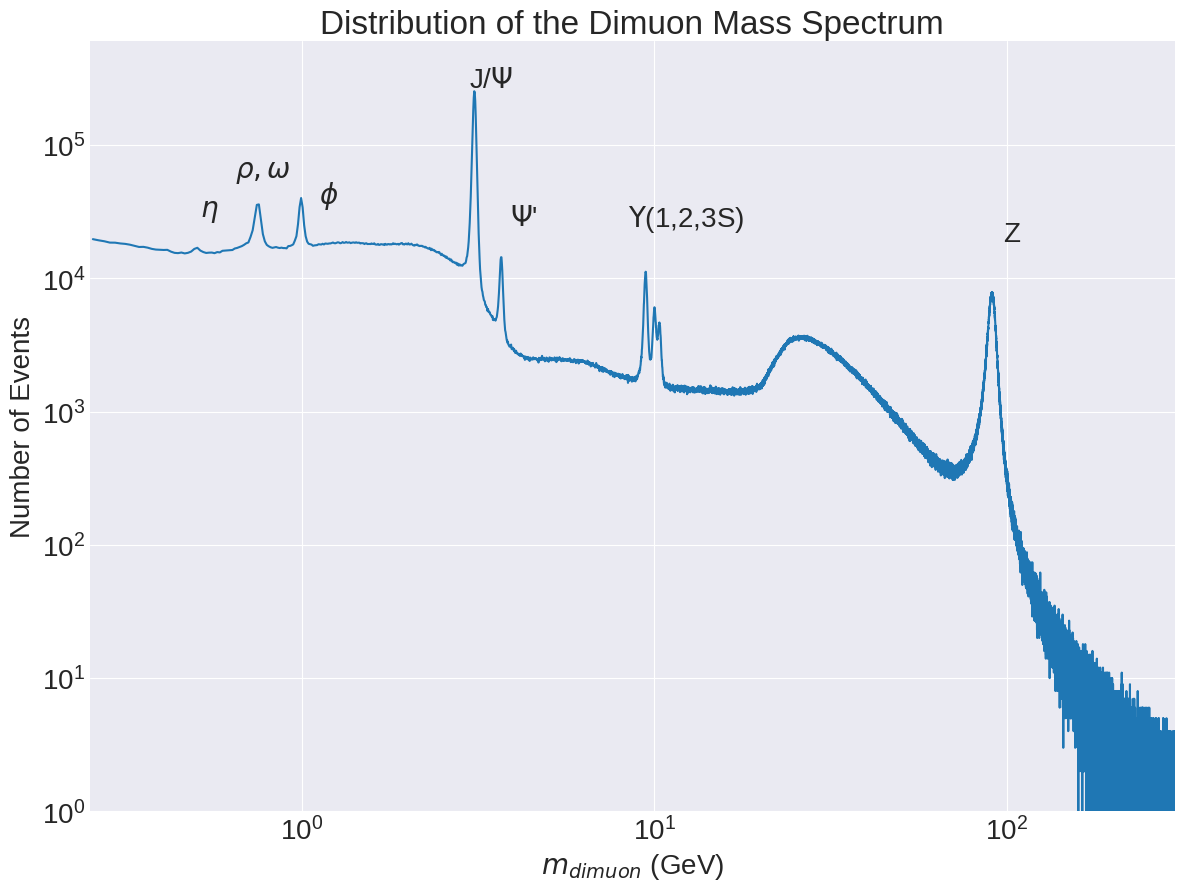

In [10]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# cut the first and last bin
x = histogram_data_pandas["value"]
y = histogram_data_pandas["count"]

# line plot
ax.plot(x, y, '-')

# the plot is in log-log axis to better show the peaks
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min_val, max_val)
ax.set_ylim(1, 6e5)

ax.set_xlabel('$m_{dimuon}$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.text(0.85, 0.75, 'Z', **txt_opts)
plt.text(0.55, 0.77, r"$\Upsilon$(1,2,3S)", **txt_opts)
plt.text(0.37, 0.95, r"J/$\Psi$", **txt_opts)
plt.text(0.40, 0.77, r"$\Psi$'", **txt_opts)
plt.text(0.22, 0.80, r"$\phi$", **txt_opts)
plt.text(0.16, 0.83, r"$\rho,\omega$", **txt_opts)
plt.text(0.11, 0.78, r"$\eta$", **txt_opts);

plt.show()

In [11]:
spark.stop()